In [7]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

# LR script

# Only block to edit in LR script

In [8]:
# Introduce variables
# Note that this script expects raw data to be in "non-batch-corrected" adata.raw.X. 

# Required: Introduce the path you'd like to save figures or data to 
save_path = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/LR_human_gastrulation_ys/"

# Required: Name of first object
data1 = "_gastrulation"
# Provide path to obj1 // landscape/training data
Object1 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/gastrulation_data_human_210521/A1_V1_human_gastrulation_raw.h5ad"
# Provide categorical to join between datasets
cat1 = "sub_cluster"

# Required: Name of second object
data2 = "_ys"
# Provide path to obj2 // prediction/projection data
Object2 = "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A1.210312_lvl5_ys_for_yolk.h5ad"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Required: LR Model Options
penalty='elasticnet' # can be ["l1","l2","elasticnet"]
sparcity=0.2
max_iter = 200 #Increase if experiencing max iter issues
l1_ratio = 0.5 #If using elasticnet, tis controls the ratio between l1 and l2

# Optional: Batch correction options (this is for correction of eventual combined dataset for data1 and data2)
# If you do not have a batch variable for either data1 or data2, please add a "filler" column in the relevent adata.obs
# for the purposes of batch_correction and batch args below.
# e.g., adata.obs["whatever"] = "something"; batch="whatever"
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ["tissue","orig_ident",] # Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2

# Optional: miscellaneous Options.   
subsample_train = False # Samples the training data to the smallest fraction (highly dependent on resolution of input celltype categorical). This corrects for proportional differences between celltype labels of interest in the training data. E.g., training data has 50,000 B cells, 20,000 T cells and 100 HSCs. This function will subsample all training to 100 cells per cell type. 
subsample_prop = 0.2 # Give this option a proprtion to subsample to(e.g 0.2), if NA given, will subsample to smallest population
subsample_predict = True
subsample_prop_predict = 0.5
remove_non_high_var = True

train_x = 'X_pca' # Define the resource to train and predict on, PCA, X or UMAP (#if you wish to use gene expression, train_x = 'X')
remove_effect_of_custom_gene_list = 'NA' # "./cell_cycle_genes.csv" #remove a custom list of genes from just the variable genes to compute PCA from. Your .csv should have HGNC gene names in the first column to be read in as a vector, any column name is fine.
use_raw = True # Do you want to use adata.raw.X (recommended)

# Minor Corrections

In [9]:
adata2 = sc.read(Object2)
adata = sc.read(Object1)

In [10]:
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)
#adata2.obs["tissue"] = "gastrulation"
#adata2.obs["tissue"]

In [11]:
res = 0.005
key_add = 'cell.labels'
adata2.obs[key_add] = adata2.obs["cell.labels"]
sc.tl.leiden(adata2, resolution= res,key_added= key_add, random_state=26, n_iterations=10, restrict_to=[key_add, ['LYVE1+_Endothelium']])
sc.tl.leiden(adata2, resolution= res,key_added= key_add, random_state=26, n_iterations=10, restrict_to=[key_add, ['IL33+_Endothelium']])
#Replace all ',' with '_'
adata2.obs[key_add] = adata2.obs[key_add].astype('str')
adata2.obs[key_add] = (adata2.obs[key_add].replace({',':'_'}, regex=True))
adata2.obs[key_add] = adata2.obs[key_add].astype('category')

running Leiden clustering
    finished: found 41 clusters and added
    'cell.labels', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 56 clusters and added
    'cell.labels', the cluster labels (adata.obs, categorical) (0:00:00)


In [15]:
# Try to subcluster the Hemogenic endothelium
adata.raw = adata
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.obs["tissue"] = "gastrulation"
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)
res = 0.5
key_add = 'sub_cluster'
adata.obs['sub_cluster'] = adata.obs["sub_cluster"]
sc.tl.leiden(adata, resolution= res,key_added= key_add, random_state=26, n_iterations=-1, restrict_to=["sub_cluster", ['Blood Progenitors']])
sc.tl.leiden(adata, resolution= res,key_added= key_add, random_state=26, n_iterations=-1, restrict_to=["sub_cluster", ['Hemogenic Endothelium']])
#Replace all ',' with '_'
adata.obs[key_add] = adata.obs[key_add].astype('str')
#adata.obs[key_add] = adata.obs[key_add].astype('str') + '_' + adata.obs['origin'].astype(str)
adata.obs[key_add] = (adata.obs[key_add].replace({',':'_'}, regex=True))
# Add the anatomical site info
adata.obs[key_add] = adata.obs[key_add].astype('category')

normalizing by total count per cell
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
 

In [16]:
adata.obs[key_add]

index
SS.sc7785290    Blood Progenitors_0
SS.sc7786612                  DE(P)
SS.sc7786605      Advanced Mesoderm
SS.sc7785737       Primitive Streak
SS.sc7785398            YS Mesoderm
                       ...         
SS.sc7785965               Epiblast
SS.sc7788259       Primitive Streak
SS.sc7786123       Primitive Streak
SS.sc7786212               Epiblast
SS.sc7785932       Nascent Mesoderm
Name: sub_cluster, Length: 1195, dtype: category
Categories (21, object): ['Advanced Mesoderm', 'Axial Mesoderm', 'Blood Progenitors_0', 'Blood Progenitors_1', ..., 'PGC', 'Primitive Streak', 'YS Endoderm', 'YS Mesoderm']

# Remove cells not in YS from gastrula data

In [18]:
adata = adata[adata.obs['origin'].isin(['Yolk Sac'])]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [17]:
adata.write('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/gastrulation_data_human_210521/A1_V2_human_gastrulation_with_sub_cat_raw.h5ad')

... storing 'tissue' as categorical


In [12]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/gastrulation_data_human_210521/A1_V2_human_gastrulation_with_sub_cat_raw.h5ad')

In [13]:
adata.raw.X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
adata2.raw.X

<125519x26661 sparse matrix of type '<class 'numpy.float64'>'
	with 248250609 stored elements in Compressed Sparse Row format>

In [16]:
# remove any cells not in YS
adata2.obs

n_genes     n_counts  \
index                                                                     
F32_Yolksac_Total_FCAImmP7316900_AAACCTGAGTCTCAAC     1166  2572.521484   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCACGCATCG     2218  3597.635498   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGACGCTC      843  2031.873657   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGTAACGG      230   826.616272   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGTCACAGGCC      856  2117.313232   
...                                                    ...          ...   
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG        888  2121.159668   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG       3528  4397.775391   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG       3412  4340.039062   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT       1104  2402.240723   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA       2779  3960.290527   

                                                  orig_ident  percent_mito  \
index                                                                        
F32_Yolksac_Total_FCAImmP7316900_AAACCTGAGTCTCAAC        F32      0.000729   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCACGCATCG        F32      0.019722   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGACGCTC        F32      0.003751   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGTAACGG        F32      0.000995   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGTCACAGGCC        F32      0.000350   
...                                                      ...           ...   
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG          F80      0.005677   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG          F80      0.038240   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG          F80      0.042880   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT          F80      0.009442   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA          F80      0.095155   

                                                  fetal_ids sort_ids   tissue  \
index                                                                           
F32_Yolksac_Total_FCAImmP7316900_AAACCTGAGTCTCAAC       F32    Total  yolkSac   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCACGCATCG       F32    Total  yolkSac   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGACGCTC       F32    Total  yolkSac   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGTAACGG       F32    Total  yolkSac   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGTCACAGGCC       F32    Total  yolkSac   
...                                                     ...      ...      ...   
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG         F80    CD45N  yolkSac   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG         F80    CD45N  yolkSac   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG         F80    CD45N  yolkSac   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT         F80    CD45N  yolkSac   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA         F80    CD45N  yolkSac   

                                                            lanes stages  \
index                                                                      
F32_Yolksac_Total_FCAImmP7316900_AAACCTGAGTCTCAAC  FCAImmP7316900   CS22   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCACGCATCG  FCAImmP7316900   CS22   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGACGCTC  FCAImmP7316900   CS22   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGTAACGG  FCAImmP7316900   CS22   
F32_Yolksac_Total_FCAImmP7316900_AAACCTGTCACAGGCC  FCAImmP7316900   CS22   
...                                                           ...    ...   
F80_Yolksac_Hep_FCAImmP8096696_TTTGGTTCATCCGTGG    FCAImmP8096696   CS15   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAAGATGCCAG    FCAImmP8096696   CS15   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCAGTCGAACAG    FCAImmP8096696   CS15   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCATTCACT    FCAImmP8096696   CS15   
F80_Yolksac_Hep_FCAImmP8096696_TTTGTCATCGGATGGA    FCAImmP8096696   CS15   

                 

# Plot Umap adata

In [9]:
markers ={
'Ectoderm':  ['DLX1', 'TFAP2A', 'GATA3'],
'Primitive streak': ['TBXT', 'CDH1','FST'],
'Nascent Mesoderm': ['TBXT', 'MESP1', 'PDGFRA'],
'Axial mesoderm': ['TBXT', 'CHRD', 'NOTO'],
'Emergent Mesoderm':  ['MESP1', 'LHX1', 'OTX2', 'LEFTY2 '],
'Advanced mesoderm': ['PDGFRA', 'GATA6', 'HAND1', 'BMP4', 'FOXF1', 'SNAI2'],
'YS mesoderm': ['POSTN', 'ANXA1', 'HAND1', 'FOXF1', 'SNAI2'],
'Hemogenic Endothelial Progenitor': ['PECAM1', 'MEF2C', 'RUNX1', 'GATA1'],
'Endoderm': ['SOX17', 'GATA6', 'FOXA2', 'TTR'],
'hESC naïve' :['KLF5', 'KLF17', 'DNMT3'],
'hESC primed' :['CD24', 'THY1', 'SFRP2'],
'Primordial germ cells': ['NANOS3', 'SOX17', 'DND1', 'DPPA5', 'LAMA4'],
}

ranking genes
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by gr

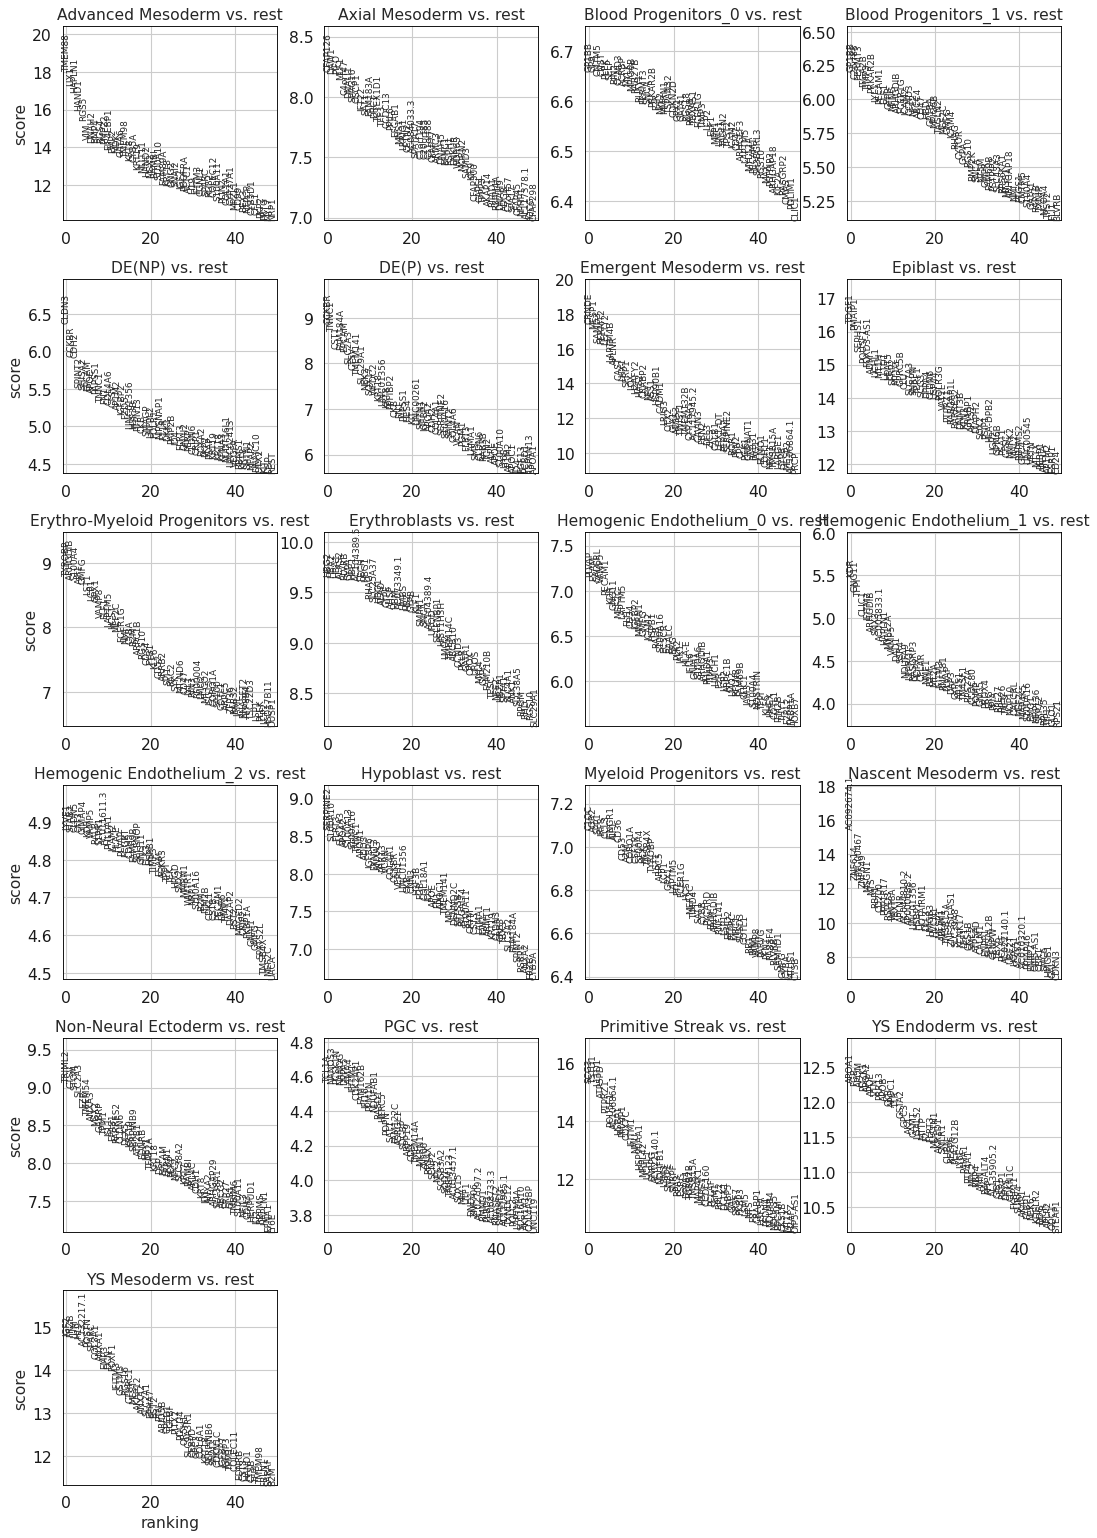

In [10]:
sc.tl.rank_genes_groups(adata, "sub_cluster", method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata, n_genes=50, sharey=False)

result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)

DE_name ="./DEGS_gastrulation.csv"
DE.to_csv(DE_name)

degs = DE[:]

if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')

n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})

concat = pd.concat([n,p,l],axis=1)

#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]

concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(5, 'p_val')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}

... storing 'clus_origin' as categorical


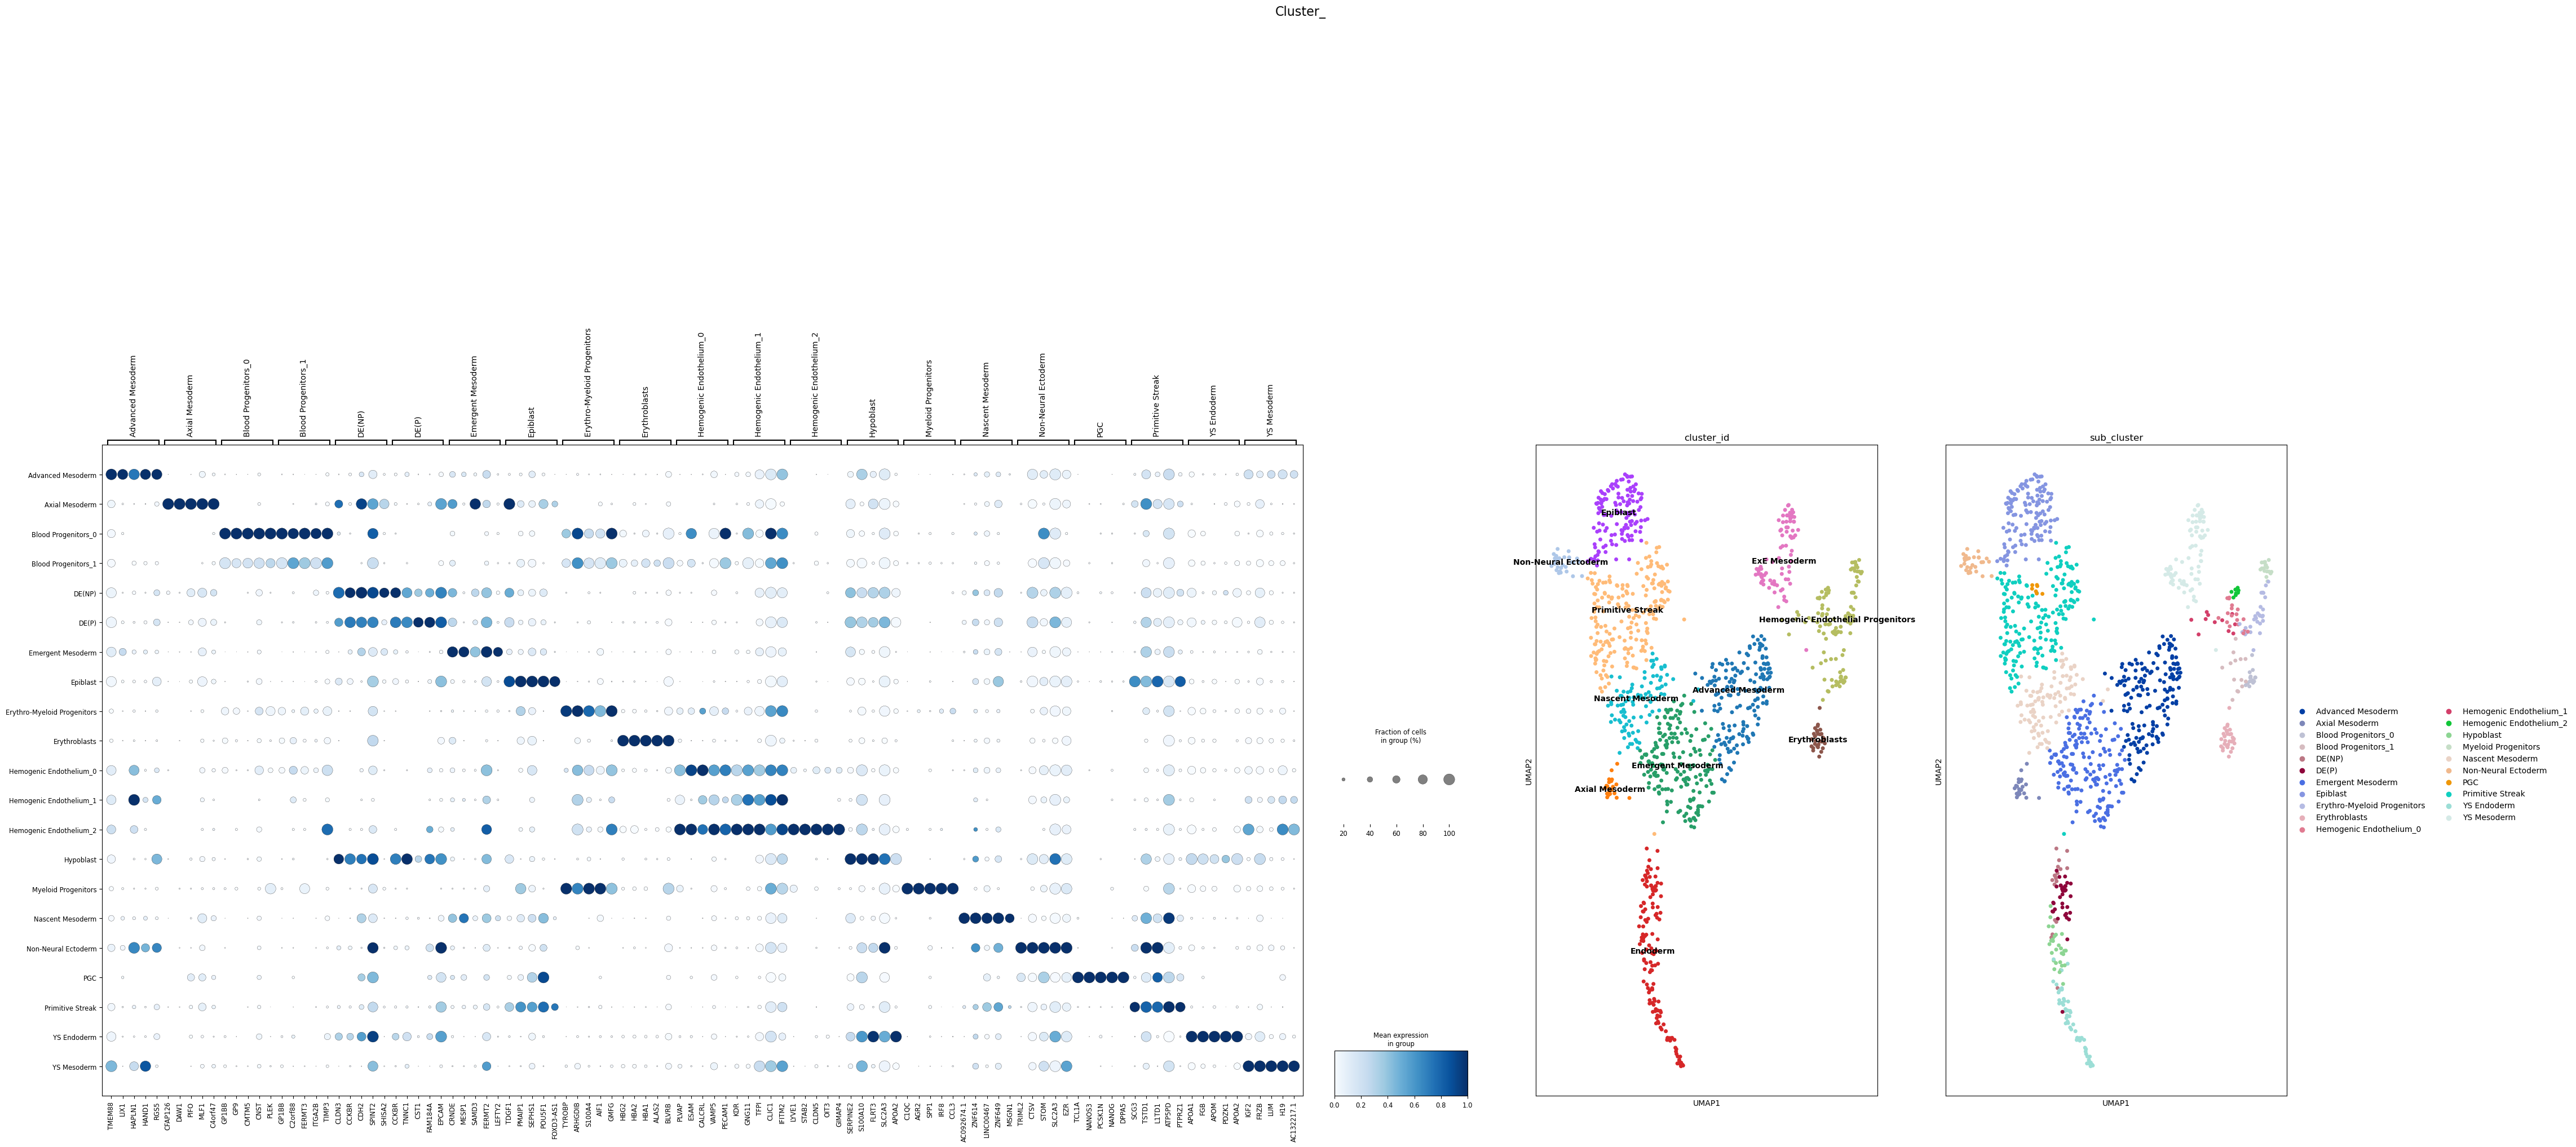

In [70]:
data_temp = adata
markers = markers
spot_var = "sub_cluster"
map1_var ="cluster_id"
map2_var = "sub_cluster"
    
import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(50,15), gridspec_kw={'wspace':0.1,'width_ratios': [4, 1,1]})
p1 =(sc.pl.dotplot(data_temp, markers, groupby=spot_var,dendrogram=False,standard_scale='var', smallest_dot=40, color_map='Blues', figsize=(15,15),ax=ax1 , show = False)) # title=i
p2 = sc.pl.umap(data_temp,color=map2_var,ax=ax3,show=False) #title=i
p3 = sc.pl.umap(adata,color=map1_var,ax=ax2,show=False,legend_loc="on data") #title=i
fig.suptitle(("Cluster_") , fontsize=16,y=1.4,x=0.55)
fig.savefig("DEGS_umaps.pdf")
    
fig.show()

# Rest of LR script

## Combining data and Preprocess

In [19]:
%%time
# Check if filepaths are good
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    #adata = sc.read(Object1)
    #adata2 =  sc.read(Object2)
    del adata.uns
    del adata2.uns
else: 
    raise TypeError("one or more .h5ad paths cannot be accessed")

# altering scanpy setting so that we can save it to our defined directory
sc._settings.ScanpyConfig(figdir=save_path)

# Combine and pre-process data to match correlations across PCA

# Module to detect shape mismatch and alternatively rebuild adata
if(use_raw==True):
    print('option detected to use raw data, proceeding to check if raw exists and if it matches data.X')
    if(scipy.sparse.issparse(adata.raw.X)):
        scipy.sparse.csr_matrix(adata.raw.X)
    if (hasattr(adata.raw, "X")):
        try: adata.X =  adata.raw.X  ; print('no mismatch in shape for adata detected')
        except: print("adata.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata = adata.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata.raw = adata
        
    if (hasattr(adata2.raw, "X")):
        if(scipy.sparse.issparse(adata2.raw.X)):
            scipy.sparse.csr_matrix(adata2.raw.X)
        try: adata2.X = adata2.raw.X ; print('no mismatch in shape for adata2 detected')
        except: print("adata2.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata2 = adata2.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata2.raw = adata2
            
# Define intersecting genes between datasets
adata_genes = list(adata.var.index)
adata2_genes = list(adata2.var.index)
keep_SC_genes = list(set(adata_genes) & set(adata2_genes))
print("keep gene list = " , len(keep_SC_genes), "adata1 gene length = ", len(adata_genes) , "adata2 gene length = ", len(adata2_genes) )

# Remove non-intersecting genes (this step will remove cite-seq data if training data is pure RNA seq)
adata_intersect1 = adata[:, keep_SC_genes]
adata = adata_intersect1
adata_intersect2 = adata2[:, keep_SC_genes]
adata2 = adata_intersect2

# Optional subsampling of training data to 
if(subsample_train == True):
    
    if not(subsample_prop=="NA"):
        print("option to subsample by proportion chosen")
        prop = subsample_prop
        data = adata.obs[:]
        grouped = data.groupby(cat1)
        df = grouped.apply(lambda x: x.sample(frac=prop))
        df = df.droplevel(cat1)
        keep = df.index
        adata = adata[adata.obs.index.isin(keep)]
    else:
        print("subsample by smallest population")
        data = adata.obs
        data = data.sample(frac=1).groupby(cat1).head(min(adata.obs.groupby(cat1).size()))
        keep = data.index
        adata = adata[adata.obs.index.isin(keep)]
        
# Optional subsampling of training data to 
if(subsample_predict == True):
    if not(subsample_prop_predict=="NA"):
        print("option to subsample by proportion chosen")
        prop = subsample_prop_predict
        data = adata2.obs[:]
        grouped = data.groupby(cat2)
        df = grouped.apply(lambda x: x.sample(frac=prop))
        df = df.droplevel(cat2)
        keep = df.index
        adata2 = adata2[adata2.obs.index.isin(keep)]
    else:
        print("subsample by smallest population")
        data = adata2.obs
        data = data.sample(frac=1).groupby(cat2).head(min(adata.obs.groupby(cat2).size()))
        keep = data.index
        adata2 = adata2[adata2.obs.index.isin(keep)]

# Create a common batch column and do simple sanity check for batch variables
if not((batch_correction == "False") and (len(batch)>1)):
    print("Batch correction option detected, proceeding to format batch variables")
    batch_var = "lr_batch"
    adata.obs["lr_batch"] = adata.obs[batch[0]]
    adata2.obs["lr_batch"] = adata2.obs[batch[1]]
else: raise TypeError("Batch correction option detected but requires at least one categorical for each dataset!")

# Create a common obs column in both datasets containing the data origin tag
common_cat = "corr_concat" 
adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1
adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
adata.obs = adata.obs.astype('category')
adata2.obs = adata2.obs.astype('category')
concat = adata2.concatenate(adata, join='inner',index_unique=None, batch_categories=None)
adata = concat[:]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
sc.pp.scale(adata, zero_center=False, max_value=None, copy=False) #zero_center=True (densifies output)

# Optionally remove genes of known confounding effect from variable list
if not (Path(remove_effect_of_custom_gene_list).is_file()):
    print("Custom gene list option is not selected or path is not readbale, proceeding with no variable removal")
else: 
    print("Custom gene removal list detected, proceeding to remove intersect from variable genes")
    regress_list = pd.read_csv(remove_effect_of_custom_gene_list)
    regress_list = regress_list.iloc[:, 0]
    adata.var["highly_variable"][adata.var.index.isin(regress_list)] = "False"

#Optionally remove genes that do not contribute to variance in combined data::Use only if training and predicting withsim reduced data    
if(remove_non_high_var==True):
    high_var = list(adata.var["highly_variable"][adata.var["highly_variable"]==True])
    adata = adata[:, adata.var["highly_variable"].isin(high_var)]   

# Now compute PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

# Batch correction options
# The script will test later which Harmony values we should use
if not(batch_correction == "False"):
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)    
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata = adata_hm[:]
    del adata_hm
elif(batch_correction == "BBKNN"):
    print("Commencing BBKNN")
    sc.external.pp.bbknn(adata, batch_key=batch_var, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 
    
print("adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!")

adata file paths detetcted, proceeding to load
option detected to use raw data, proceeding to check if raw exists and if it matches data.X
no mismatch in shape for adata detected
no mismatch in shape for adata2 detected
keep gene list =  19490 adata1 gene length =  57591 adata2 gene length =  26661
option to subsample by proportion chosen


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Batch correction option detected, proceeding to format batch variables


normalizing by total count per cell
Trying to set attribute `.obs` of view, copying.
    finished (0:00:03): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Custom gene list option is not selected or path is not readbale, proceeding with no variable removal


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:23)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Commencing harmony


2021-05-28 14:02:36,769 - harmonypy - INFO - Iteration 1 of 10
2021-05-28 14:04:52,982 - harmonypy - INFO - Iteration 2 of 10
2021-05-28 14:07:11,679 - harmonypy - INFO - Iteration 3 of 10
2021-05-28 14:09:32,772 - harmonypy - INFO - Converged after 3 iterations
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!
CPU times: user 32min 10s, sys: 54min 2s, total: 1h 26min 13s
Wall time: 9min 26s


In [20]:
adata

View of AnnData object with n_obs × n_vars = 62936 × 1487
    obs: 'n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'fetal_ids', 'sort_ids', 'tissue', 'lanes', 'stages', 'sample_type', 'gender', 'AnnatomicalPart', 'res_30', 'LouvainClustering', 'fullmeta', 'short_code', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'oldanno', 'leiden', 'leiden_sub', 'Hep', 'oldanno_2', 'Component', 'refined_cell_labels', 'predicted', 'cell_labels_back_050820', 'subcluster_annotation_back_050820', 'refined_cell_label_back_050820', '160920_cell_labels', '160920_subclusters', '160920_broad_cell_labels', 'broad_cell_label', 'cell.labels', '301020_microglia_assignment', 'restricted_301020_microglia_assignment', 'predicted_301020_microglia_assignment', 'lvl_1_cell.labels', 'lvl_2_cell.labels', 'cell_labels', 'broad_cell_labels', 'lr_batch', 'corr_concat', 'Unnamed: 0', 'X0', 'X1', 'cluster_id', 'sub_cluster', 'cluster', 'origin', 'size_factor', 'batch'
    var: 'gene.mean-0', 'gene.dispersion-0'

In [21]:
adata2

AnnData object with n_obs × n_vars = 62746 × 19490
    obs: 'n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'fetal_ids', 'sort_ids', 'tissue', 'lanes', 'stages', 'sample_type', 'gender', 'AnnatomicalPart', 'res_30', 'LouvainClustering', 'fullmeta', 'short_code', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'oldanno', 'leiden', 'leiden_sub', 'Hep', 'oldanno_2', 'Component', 'refined_cell_labels', 'predicted', 'cell_labels_back_050820', 'subcluster_annotation_back_050820', 'refined_cell_label_back_050820', '160920_cell_labels', '160920_subclusters', '160920_broad_cell_labels', 'broad_cell_label', 'cell.labels', '301020_microglia_assignment', 'restricted_301020_microglia_assignment', 'predicted_301020_microglia_assignment', 'lvl_1_cell.labels', 'lvl_2_cell.labels', 'cell_labels', 'broad_cell_labels', 'lr_batch', 'corr_concat'
    var: 'gene.mean', 'gene.dispersion', 'gene.dispersion.scaled', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_fdg', 'X

In [22]:
list(adata.obs["corr_concat"].unique())

['DC2_ys',
 'Erythroid_ys',
 'NK_ys',
 'Early_Erythroid_ys',
 'Macrophage_ys',
 'MPP_ys',
 'Lymphoid_progenitor_ys',
 'ILC_precursor_ys',
 'MK_ys',
 'Eo_Basophil_ys',
 'Epithelium_ys',
 'Promonocyte_ys',
 'microglia_ys',
 'Endoderm_ys',
 'Fibroblast_ys',
 'LYVE1+_Endothelium_0_ys',
 'Smooth_Muscle_ys',
 'Mast_cell_ys',
 'Monocyte_ys',
 'IL33+_Endothelium_0_ys',
 'Eo_Baso_Mast_precursor_ys',
 'MOP_ys',
 'Mac_DC_precursor_ys',
 'Monocyte_Macrophage_ys',
 'MEMP_ys',
 'Neutrophil_precursor_ys',
 'HSC_ys',
 'LMPP_ys',
 'CMP_ys',
 'MPP2_ys',
 'Blood Progenitors_0_gastrulation',
 'YS Mesoderm_gastrulation',
 'YS Endoderm_gastrulation',
 'Hemogenic Endothelium_2_gastrulation',
 'Hemogenic Endothelium_0_gastrulation',
 'Erythroblasts_gastrulation',
 'Erythro-Myeloid Progenitors_gastrulation',
 'Nascent Mesoderm_gastrulation',
 'Blood Progenitors_1_gastrulation',
 'Myeloid Progenitors_gastrulation',
 'DE(NP)_gastrulation']

## Logistic regression function to train data set and transfer labels

In [23]:
# This function require compute power, will take a while 

def LR_compare(adata, train_x, train_label, subset_predict, subset_train, penalty=penalty, sparcity=sparcity, 
               col_name='predicted'):

    # adata - training+prediction adata object (combined). Pre-processed already
    # sparsity - larger sparsity, more bins, more conservative predictions, less accurate. Low sparist for clean output
                # A value of 0.2 is reasonable for L2 ridge regression
    # penalty - acts as buffer for assigning bins too harshly
    # train_x - arg refers to where you would like to derive your training reference from, i.e., GEX (X) or/elif.
                # PCA/UMAP in obsm. The two 'if' statements below handle train_x differently based on this
                # Based on train_x, the loops below compute 'train_label' (cell type values in training/landscape data) 
                # and 'predict_x'(prediction data equivalent of train_x)
    # train_label - cell type values in training/landscape data
    # subset_predict - mandatory subset of predict_x which contains metadata for expression
    # subset_train - mandatory subset of train_x which contains metadata for expression
    
    # Redefine LR parameters 'penalty' and 'sparsity' if you would like to deviate from defaults set above
    
    # Assign 'lr' as sklearn logistic regression func, with penalty and sparsity defined above
    lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter)
    
    if (penalty == "l1"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual = True, solver = 'liblinear')
    if (penalty == "elasticnet"):
        lr = LogisticRegression(penalty = penalty, C = sparcity, max_iter =  max_iter, dual=False,solver = 'saga',l1_ratio=l1_ratio)

    if train_x == 'X':
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        #train_x = adata.X,
        # Define prediction parameters
        #predict_x = train_x
        #train_x = train_x[subset_train, :] # issue line! subset_train = np.array(adata.obs[common_cat].isin(group1))
                                           # group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
                                           # Data1_group = data1 = healthy skin data , adata containing subsetting data to get metadata for expression prediction
                                           # adata.X = adata.X[np.array(adata.obs[common_cat].isin(group1)), :]
                                           # train_x = train_x[adata.obs[common_cat].isin(group1)]
                        
        #predict_x = train_x
        #predict_x = predict_x[subset_predict]
        train_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_train].index))]
        predict_x = adata.X[adata.obs.index.isin(list(adata.obs[subset_predict].index))]

    elif train_x in adata.obsm.keys():
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]
        # Define prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

    # Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
    model = lr.fit(train_x, train_label)
    lr.fit(train_x, train_label)
    predict = lr.predict_proba(predict_x)

    # Create prediction table and map to adata.obs (in adata.obs["predict"] in the combined object), for the cells that
    # are in predict dataset
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])

# Function to plot heatmap by percentage
def plot_df_heatmap(df, cmap='viridis', title=None, figsize=(7, 7), rotation=90, save=None, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df, cmap=cmap, aspect='auto', **kwargs)
    if 0 < rotation < 90:
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'center'
    plt.xticks(
        range(len(df.columns)),
        df.columns,
        rotation=rotation,
        horizontalalignment=horizontalalignment,
    )
    plt.yticks(range(len(df.index)), df.index)
    if title:
        fig.suptitle(title)
    #fig.colorbar(im)
    if save:
        plt.savefig(fname=save, bbox_inches='tight', pad_inches=0.1)

# Plot probability table by html
def cross_table(adata, x, y, normalise=None, highlight=False, subset=None):                                                                                                                                                                                              
    """Make a cross table comparing two categorical annotations
    """
    x_attr = adata.obs[x]
    y_attr = adata.obs[y]
    if subset is not None:
        x_attr = x_attr[subset]
        y_attr = y_attr[subset]
    crs_tbl = pd.crosstab(x_attr, y_attr)
    if normalise == 'x':
        x_sizes = x_attr.groupby(x_attr).size().values
        crs_tbl = (crs_tbl.T / x_sizes).round(2).T
    elif normalise == 'y':
        y_sizes = x_attr.groupby(y_attr).size().values
        crs_tbl = (crs_tbl / y_sizes).round(2)
    if highlight:
        return crs_tbl.style.background_gradient(cmap='viridis', axis=0)
    return crs_tbl

In [24]:
# Define the separator category in the column of interest, this works by partial matches and enables a-symmetric 
# comparisons
Data1_group = data1
Data2_group = data2
# Define the common .obs column between concatinated data
common_cat = "corr_concat"

# This block defines subset_predict and subset_train and also runs LR_compare function
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
group1 = list(group1)
group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
group2 = list(group2)
subset_predict = np.array(adata.obs[common_cat].isin(group2))
subset_train = np.array(adata.obs[common_cat].isin(group1))
train_label = (adata.obs[common_cat][adata.obs[common_cat].isin(group1)]).values

LR_compare(adata, train_x, train_label, subset_predict, subset_train, sparcity=sparcity, col_name='predicted')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
Trying to set attribute `.obs` of view, copying.


## Plotting output of LR model

In [25]:
# Plotting purposes - Subset data to only contain prediction data with new predicted labelså

# Make adata the predicted data with projected annotations in adata.obs["predicted"]. "corr_concat" contains old 
# cell.labels and dataset name combined 
common_cat = "corr_concat"
adata_concat = adata[:]
adata = adata[adata.obs["predicted"].isin(group1)]
adata = adata[adata.obs["corr_concat"].isin(group2)]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Table showing number of cells predicted in each category 

In [26]:
# The results, are displayed in a python notebook or rendered as a html (just for quick visualisation, not saving)
# This table represents probability (binary cell type assignment) - numbers represent number of cells
# Columns contain number of original cells from adata2 that are now labelled using the training dataset, adata1
# (as shown on y axis)
crs_tbl = cross_table(adata, x = 'predicted', y = common_cat, highlight = True)
crs_tbl

### Heatmap showing number of cells predicted in each category

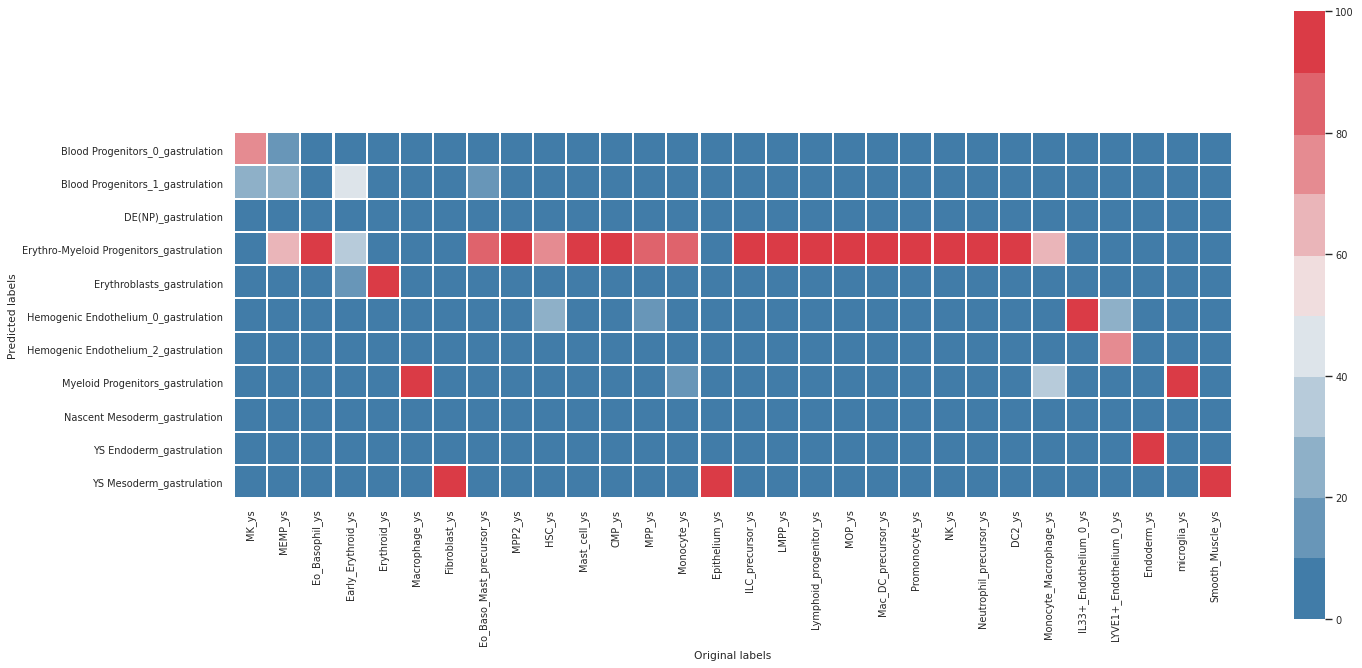

In [27]:
x = 'predicted'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)
    
# Sort df columns by rows
crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,20))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions.pdf")
crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

In [31]:
adata.obs.to_csv("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/ys_gastrulation_predictions_YS_gastrula_only.csv")

In [32]:
adata

View of AnnData object with n_obs × n_vars = 62746 × 1487
    obs: 'n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'fetal_ids', 'sort_ids', 'tissue', 'lanes', 'stages', 'sample_type', 'gender', 'AnnatomicalPart', 'res_30', 'LouvainClustering', 'fullmeta', 'short_code', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'oldanno', 'leiden', 'leiden_sub', 'Hep', 'oldanno_2', 'Component', 'refined_cell_labels', 'predicted', 'cell_labels_back_050820', 'subcluster_annotation_back_050820', 'refined_cell_label_back_050820', '160920_cell_labels', '160920_subclusters', '160920_broad_cell_labels', 'broad_cell_label', 'cell.labels', '301020_microglia_assignment', 'restricted_301020_microglia_assignment', 'predicted_301020_microglia_assignment', 'lvl_1_cell.labels', 'lvl_2_cell.labels', 'cell_labels', 'broad_cell_labels', 'lr_batch', 'corr_concat', 'Unnamed: 0', 'X0', 'X1', 'cluster_id', 'sub_cluster', 'cluster', 'origin', 'size_factor', 'batch'
    var: 'gene.mean-0', 'gene.dispersion-0'

### Proportion of cells per group

In [29]:
prop = adata.obs.groupby('predicted').count()
prop['percentage'] = (prop.iloc[:,6]/prop.iloc[:,6].sum())*100
prop = prop['percentage']
prop.to_csv(save_path + "/pre-freq_predicted_prop.csv")
prop

predicted
Blood Progenitors_0_gastrulation             0.540273
Blood Progenitors_1_gastrulation             0.482899
DE(NP)_gastrulation                          0.007969
Erythro-Myeloid Progenitors_gastrulation     3.235266
Erythroblasts_gastrulation                  41.769993
Hemogenic Endothelium_0_gastrulation         1.926816
Hemogenic Endothelium_2_gastrulation         2.436809
Myeloid Progenitors_gastrulation            26.870239
Nascent Mesoderm_gastrulation                0.001594
YS Endoderm_gastrulation                     2.412903
YS Mesoderm_gastrulation                    20.315239
Name: percentage, dtype: float64

# Look at the anatomical site each heam_endo cluster was derived from

In [30]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/gastrulation_data_human_210521/A1_V2_human_gastrulation_with_sub_cat_raw.h5ad')

In [65]:
prop.unstack(level='sub_cluster')

sub_cluster  Advanced Mesoderm  Axial Mesoderm  Blood Progenitors_0  \
origin                                                                
Caudal                      95              23                    0   
Rostral                     69               0                    0   
Yolk Sac                     0               0                   15   

sub_cluster  Blood Progenitors_1  DE(NP)  DE(P)  Emergent Mesoderm  Epiblast  \
origin                                                                         
Caudal                         3       4     13                129        73   
Rostral                        1      13     22                 56        60   
Yolk Sac                      10       1      0                  0         0   

sub_cluster  Erythro-Myeloid Progenitors  Erythroblasts  ...  \
origin                                                   ...   
Caudal                                 5              6  ...   
Rostral                                1              0  ...   
Yolk Sac                              22             26  ...   

sub_cluster  Hemogenic Endothelium_1  Hemogenic Endothelium_2  Hypoblast  \
origin                                                                     
Caudal                             5                        0          2   
Rostral                            6                        0         27   
Yolk Sac                           0                        8          0   

sub_cluster  Myeloid Progenitors  Nascent Mesoderm  Non-Neural Ectoderm  PGC  \
origin                                                                         
Caudal                         3                97                    6    7   
Rostral                        2                 0                   23    0   
Yolk Sac                      12                 1                    0    0   

sub_cluster  Primitive Streak  YS Endoderm  YS Mesoderm  
origin                                                   
Caudal                    187            4            2  
Rostral                     8           24           24  
Yolk Sac                    0           25           57  

[3 rows x 21 columns]

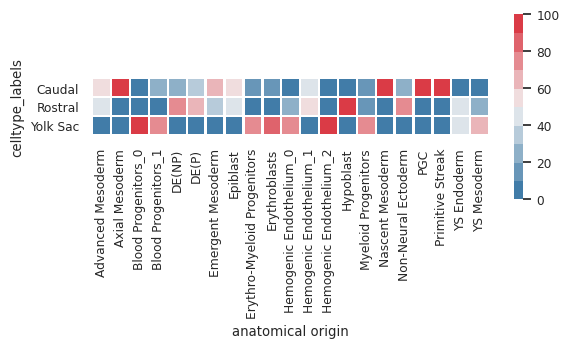

In [69]:
prop = adata.obs.groupby(['sub_cluster','origin']).count()
prop = prop.iloc[:,1]
prop = prop.unstack(level='sub_cluster')
prop  = prop/prop[prop.columns].sum()*100
#prop[prop['sub_cluster']].contains(['Hemogenic Endothelium'])
g = sns.heatmap(prop, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("anatomical origin")
plt.ylabel("celltype_labels")
plt.savefig(save_path + "/gastrulation_anatomical_origin_prop.pdf")
crs_tbl.to_csv(save_path + "/gastrulation_anatomical_origin_prop.csv")

In [36]:
adata.obs['clus_origin']

index
SS.sc7785290    Blood Progenitors_0_Yolk Sac
SS.sc7786612                   DE(P)_Rostral
SS.sc7786605       Advanced Mesoderm_Rostral
SS.sc7785737         Primitive Streak_Caudal
SS.sc7785398            YS Mesoderm_Yolk Sac
                            ...             
SS.sc7785965                 Epiblast_Caudal
SS.sc7788259         Primitive Streak_Caudal
SS.sc7786123         Primitive Streak_Caudal
SS.sc7786212                 Epiblast_Caudal
SS.sc7785932         Nascent Mesoderm_Caudal
Name: clus_origin, Length: 1195, dtype: object

# Plot the overlay

In [33]:
adata_concat

View of AnnData object with n_obs × n_vars = 62936 × 1487
    obs: 'n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'fetal_ids', 'sort_ids', 'tissue', 'lanes', 'stages', 'sample_type', 'gender', 'AnnatomicalPart', 'res_30', 'LouvainClustering', 'fullmeta', 'short_code', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'oldanno', 'leiden', 'leiden_sub', 'Hep', 'oldanno_2', 'Component', 'refined_cell_labels', 'predicted', 'cell_labels_back_050820', 'subcluster_annotation_back_050820', 'refined_cell_label_back_050820', '160920_cell_labels', '160920_subclusters', '160920_broad_cell_labels', 'broad_cell_label', 'cell.labels', '301020_microglia_assignment', 'restricted_301020_microglia_assignment', 'predicted_301020_microglia_assignment', 'lvl_1_cell.labels', 'lvl_2_cell.labels', 'cell_labels', 'broad_cell_labels', 'lr_batch', 'corr_concat', 'Unnamed: 0', 'X0', 'X1', 'cluster_id', 'sub_cluster', 'cluster', 'origin', 'size_factor', 'batch'
    var: 'gene.mean-0', 'gene.dispersion-0'

In [34]:
adata

View of AnnData object with n_obs × n_vars = 62746 × 1487
    obs: 'n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'fetal_ids', 'sort_ids', 'tissue', 'lanes', 'stages', 'sample_type', 'gender', 'AnnatomicalPart', 'res_30', 'LouvainClustering', 'fullmeta', 'short_code', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'oldanno', 'leiden', 'leiden_sub', 'Hep', 'oldanno_2', 'Component', 'refined_cell_labels', 'predicted', 'cell_labels_back_050820', 'subcluster_annotation_back_050820', 'refined_cell_label_back_050820', '160920_cell_labels', '160920_subclusters', '160920_broad_cell_labels', 'broad_cell_label', 'cell.labels', '301020_microglia_assignment', 'restricted_301020_microglia_assignment', 'predicted_301020_microglia_assignment', 'lvl_1_cell.labels', 'lvl_2_cell.labels', 'cell_labels', 'broad_cell_labels', 'lr_batch', 'corr_concat', 'Unnamed: 0', 'X0', 'X1', 'cluster_id', 'sub_cluster', 'cluster', 'origin', 'size_factor', 'batch'
    var: 'gene.mean-0', 'gene.dispersion-0'

In [4]:
adata = adata2[:]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [30]:
obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/ys_gastrulation_predictions.csv')

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (20,24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
adata.obs = obs

In [72]:
adata_predicted = adata[:]
adata = adata_concat[:]

In [113]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:07)


In [79]:
adata.obs["tissue"] = adata.obs["tissue"].str.replace('VA','yolkSac')
adata.obs["tissue"].unique()

Trying to set attribute `.obs` of view, copying.


array(['yolkSac', 'gastrulation'], dtype=object)

In [80]:
adata.obs['corr_concat']

index
F32_Yolksac_Total_FCAImmP7316900_AAACCTGAGTCTCAAC                     Erythroid_ys
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCACGCATCG                           DC2_ys
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGACGCTC                     Erythroid_ys
F32_Yolksac_Total_FCAImmP7316900_AAACCTGCAGTAACGG                     Erythroid_ys
F32_Yolksac_Total_FCAImmP7316900_AAACCTGTCACAGGCC                     Erythroid_ys
                                                                 ...              
SS.sc7785965                                                 Epiblast_gastrulation
SS.sc7788259                                         Primitive Streak_gastrulation
SS.sc7786123                                         Primitive Streak_gastrulation
SS.sc7786212                                                 Epiblast_gastrulation
SS.sc7785932                                         Nascent Mesoderm_gastrulation
Name: corr_concat, Length: 63941, dtype: object

... storing 'num' as categorical
... storing 'corr_concat_num' as categorical


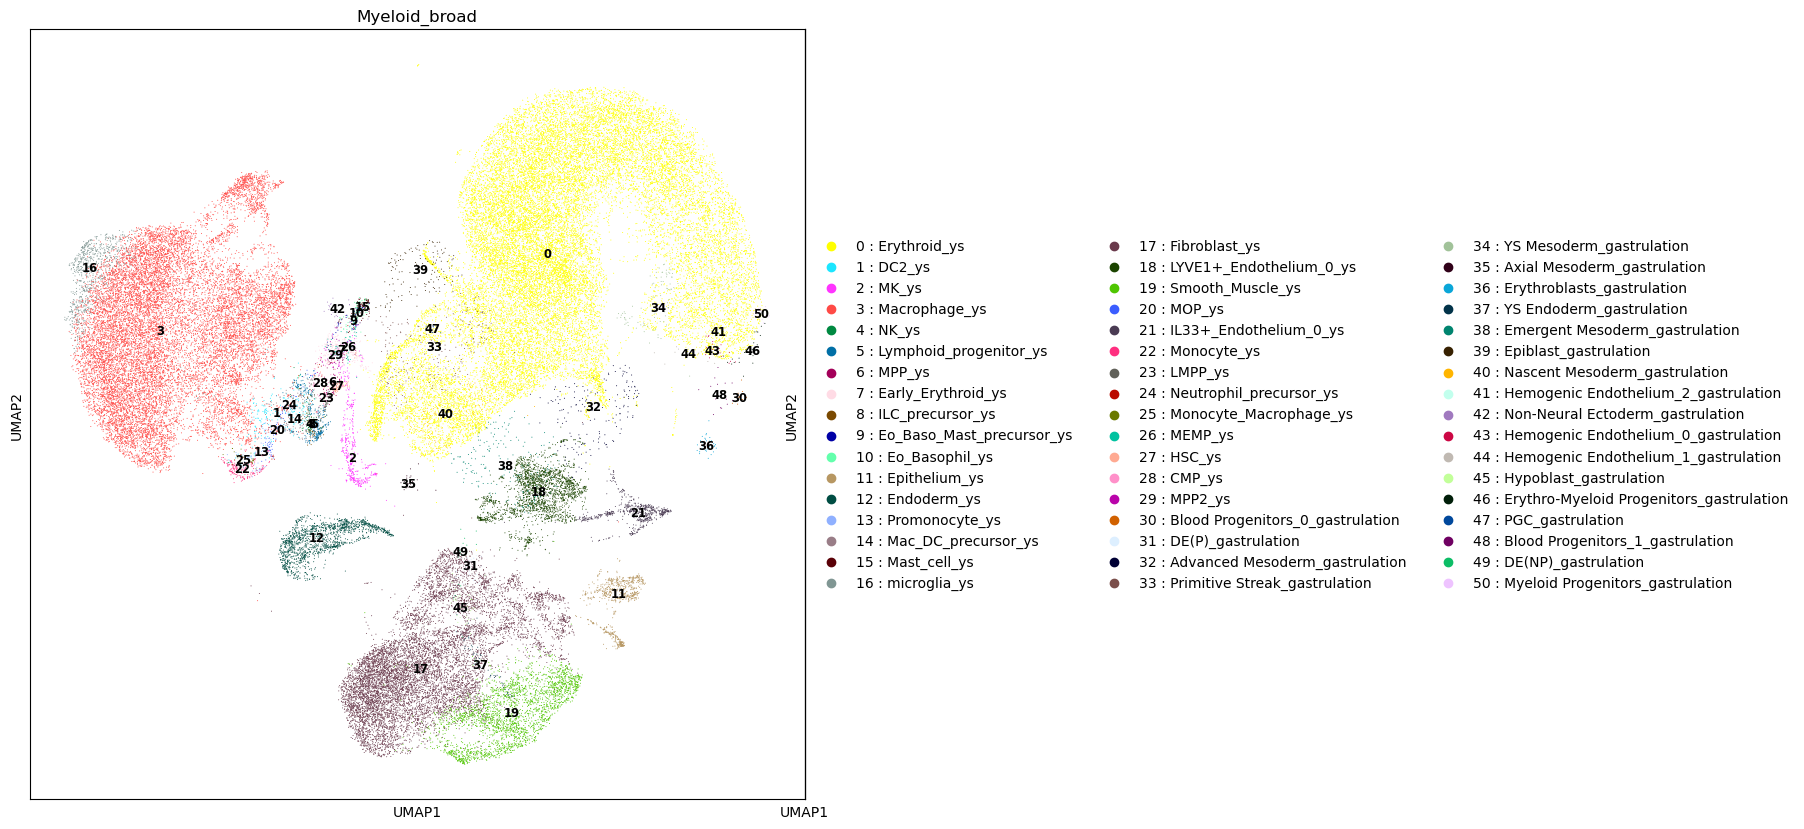

In [82]:
var = "corr_concat"
#Create color dictionary
cells = list(adata.obs['corr_concat'].unique())
col = list(range(0, len(adata.obs[var].unique())))
#col = adata.uns['cell.labels_colors']
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

col_pal = [ "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72",]

import matplotlib
matplotlib.rcdefaults() #Reset matplot lb deafults as seaborne tends to mess with this
fig, (ax1, ax2,) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata, color = (var+'_num') ,ax=ax2,show=False,title="", palette= col_pal) #title=i
p3 = sc.pl.umap(adata, color = "num",legend_loc="on data",size=2,legend_fontsize='small',ax=ax1,show=False,title="Myeloid_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"_num.pdf",bbox_inches='tight')

In [ ]:
#Plot UMAP S2 overlay
fig, ax = plt.subplots(1,figsize=(12,8))
ax.scatter(adata.obsm['X_umap'][:,0][adata.obs["tissue"]=="ys"], adata.obsm['X_umap'][:,1][adata.obs["tissue"]=="ys"],c=adata.obs['col'][adata.obs["seq_source"]=="nan"],s=1)
ax.scatter(adata.obsm['X_umap'][:,0][adata.obs["tissue"]=="SS2"], adata.obsm['X_umap'][:,1][adata.obs["seq_source"]=="SS2"],c=adata.obs['col'][adata.obs["seq_source"]=="SS2"], s=100,marker=11)
plt.savefig("./figures/umap_SS2_overlay")

# Create mappable field

In [104]:
adata.obs["ys_only"] = adata.obs['corr_concat'][:]
adata.obs["ys_only"] = adata.obs["ys_only"].astype(str)
adata.obs["ys_only"][adata.obs["tissue"].isin(['gastrulation'])] = 'gastrulation'

<ipython-input-104-eaec89403229>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["ys_only"][adata.obs["tissue"].isin(['gastrulation'])] = 'gastrulation'


In [105]:
adata.obs["gas_only"] = adata.obs['corr_concat'][:]
adata.obs["gas_only"] = adata.obs["gas_only"].astype(str)
adata.obs["gas_only"][adata.obs["tissue"].isin(['yolkSac'])] = 'ys'

<ipython-input-105-02fb9bd48ebe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["gas_only"][adata.obs["tissue"].isin(['yolkSac'])] = 'ys'


In [120]:
var = 'gas_only'
plot_tissue = 'gastrulation'

In [121]:
cells = list(adata.obs[var][adata.obs["tissue"].isin([plot_tissue])].unique())
cells.sort()
#pal = pal[pal["categories"].isin(cells)]
#cells.append(alternate_name)
#col = list(range(0,len(cells)))
#Add gray color for alternate category
#pal.loc[len(pal)+1]= [alternate_name,"#808080"]
#pal = pal.set_index('categories')
#pal = pal.loc[cells]
#col_pal = list(pal["color"])
pal = ['#ff0000',    '#94BFB1',    '#B49EC8',    '#E0EE70',    '#EE943E',    '#4C7BAB',    '#E78AB8',    '#AFBFCC',    '#FF993F',    "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF"]

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'corr_concat_num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ys_only' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'ys_only_num' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'gas_only' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'gas_only_num' as categorical
Trying to set attribu

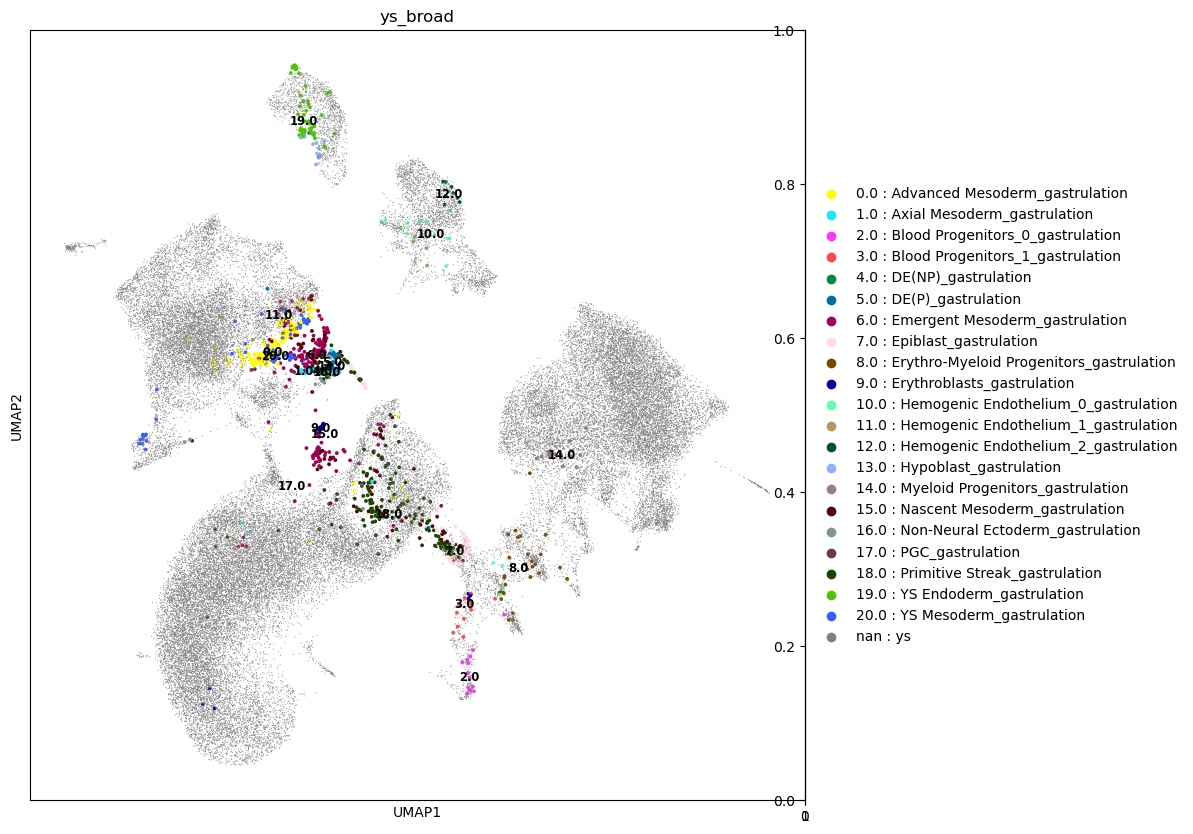

In [123]:
dic = dict(zip(cells,col))

#Create a mappable field
adata.obs['num'] = adata.obs[var]
#map to adata.obs.col to create a caterorical column
adata.obs['num'] = adata.obs['num'].map(dic)

##Map to a pallete to use with umap
#cells_list = pd.DataFrame(adata.obs["cell.labels"].cat.categories)
#cells_list['col'] = cells_list[0].map(dic)
#col_pal = list(cells_list['col'])
adata.obs['num'] = adata.obs['num'].astype(str)
adata.obs[var+'_num'] = adata.obs['num'].astype(str) + " : " + adata.obs[var].astype(str)

import matplotlib
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10), gridspec_kw={'wspace':0,'width_ratios': [1,0]})
p2 = sc.pl.umap(adata[adata.obs["tissue"].isin([plot_tissue])], color = (var+'_num') ,ax=ax1,size=30,legend_fontsize='xx-small', show=False,title="", palette= col_pal) #title=i
p4 = sc.pl.umap(adata[~adata.obs["tissue"].isin([plot_tissue])], color = (var+'_num') ,ax=ax1,size=2,show=False,title="", palette= ["#808080"]) #title=i
p3 = sc.pl.umap(adata[adata.obs["tissue"].isin([plot_tissue])], color = "num",legend_loc="on data",size=2,legend_fontsize='small',ax=ax1,show=False,title="ys_broad", palette= col_pal) #title=i

fig.savefig('./'+var+"_"+plot_tissue+"_num.pdf",bbox_inches='tight')

## Clustering 

In [25]:
# Optional clustering 
#res = 5
#key_add = 'leiden'
#adata.obs[key_add] = "nan"
#sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

In [26]:
#cluster_prediction = "clus_prediction"
#clusters_reassign = "leiden"
#lr_predicted_col = 'predicted'

In [27]:
#adata.obs[cluster_prediction] = adata.obs.index
#for z in adata.obs[clusters_reassign].unique():
#    df = adata.obs
#    df = df[(df[clusters_reassign].isin([z]))]
#    df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
#    freq_arranged = df_count.index
#    cat = freq_arranged[0]
#    df.loc[:,cluster_prediction] = cat
#    adata.obs.loc[adata.obs[clusters_reassign] == z, [cluster_prediction]] = cat

### Heatmap showing cells in predicted clusters

In [28]:
# Create a concat col for old + predicted annots
#adata.obs['annot_clus_prediction_concat'] = adata.obs[cat1].astype(str) + "_" + adata.obs['clus_prediction'].astype(str)
#
#x='clus_prediction'
#y = common_cat
#
#y_attr = adata.obs[y]
#x_attr = adata.obs[x]
#crs = pd.crosstab(x_attr, y_attr)
#crs_tbl = crs
#for col in crs_tbl :
#    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)

#plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
#pal = sns.diverging_palette(240, 10, n=10)
#plt.figure(figsize=(20,10))
#sns.set(font_scale=0.8)
#g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.3})
#plt.xlabel("Original labels")
#plt.ylabel("Predicted labels")
#plt.savefig(save_path + "/LR_predictions_consensus.pdf")
#crs_tbl.to_csv(save_path + "/post-freq_LR_predictions_consensus_supp_table.csv")

In [29]:
#prop = adata.obs.groupby('clus_prediction').count()
#prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
#prop = prop['percentage']
#prop.to_csv(save_path + "/post-freq_predicted_leiden_consensus_prop.csv")
#prop

computing UMAP


/home/jovyan/my-conda-envs/skin_data_env/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 682 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:47)


... storing 'orig.ident' as categorical
... storing 'nCount_RNA' as categorical
... storing 'nFeature_RNA' as categorical
... storing 'patient' as categorical
... storing 'tum.norm' as categorical
... storing 'level1_celltype' as categorical
... storing 'level2_celltype' as categorical
... storing 'level3_celltype' as categorical
... storing 'batch_id' as categorical
... storing 'lr_batch' as categorical
... storing 'corr_concat' as categorical
... storing 'sample_id' as categorical
... storing 'Status' as categorical
... storing 'Site' as categorical
... storing 'Tissue' as categorical
... storing 'Enrichment' as categorical
... storing 'Location' as categorical
... storing 'Sex' as categorical
... storing 'Age' as categorical
... storing 'stage' as categorical
... storing 'full_clustering' as categorical
... storing 'integrated_sample_id' as categorical
... storing 'orig_cell_labels' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical
..

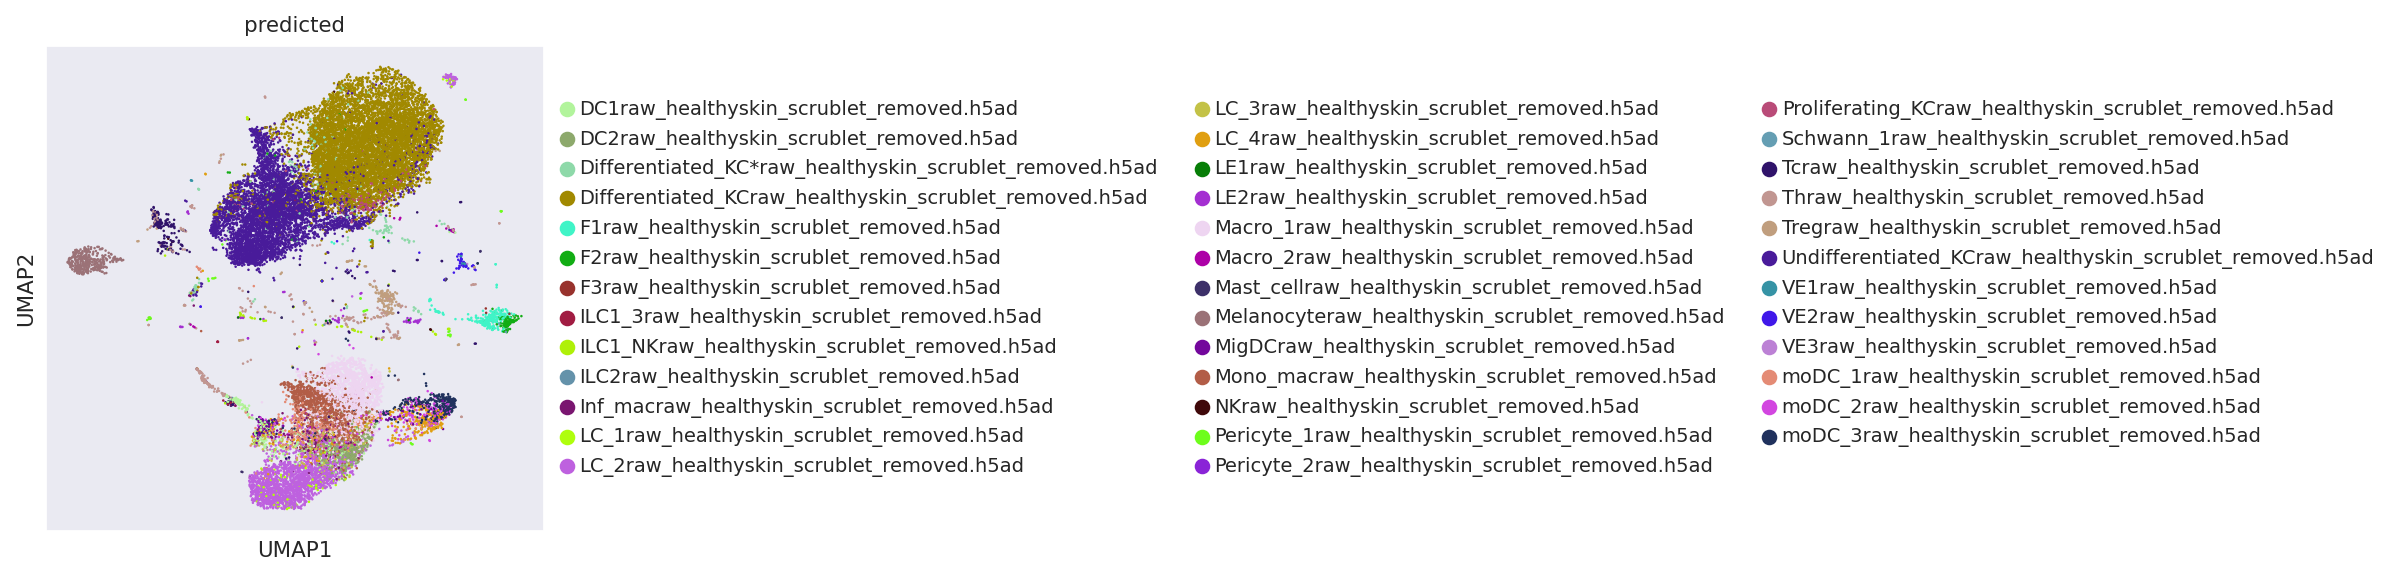

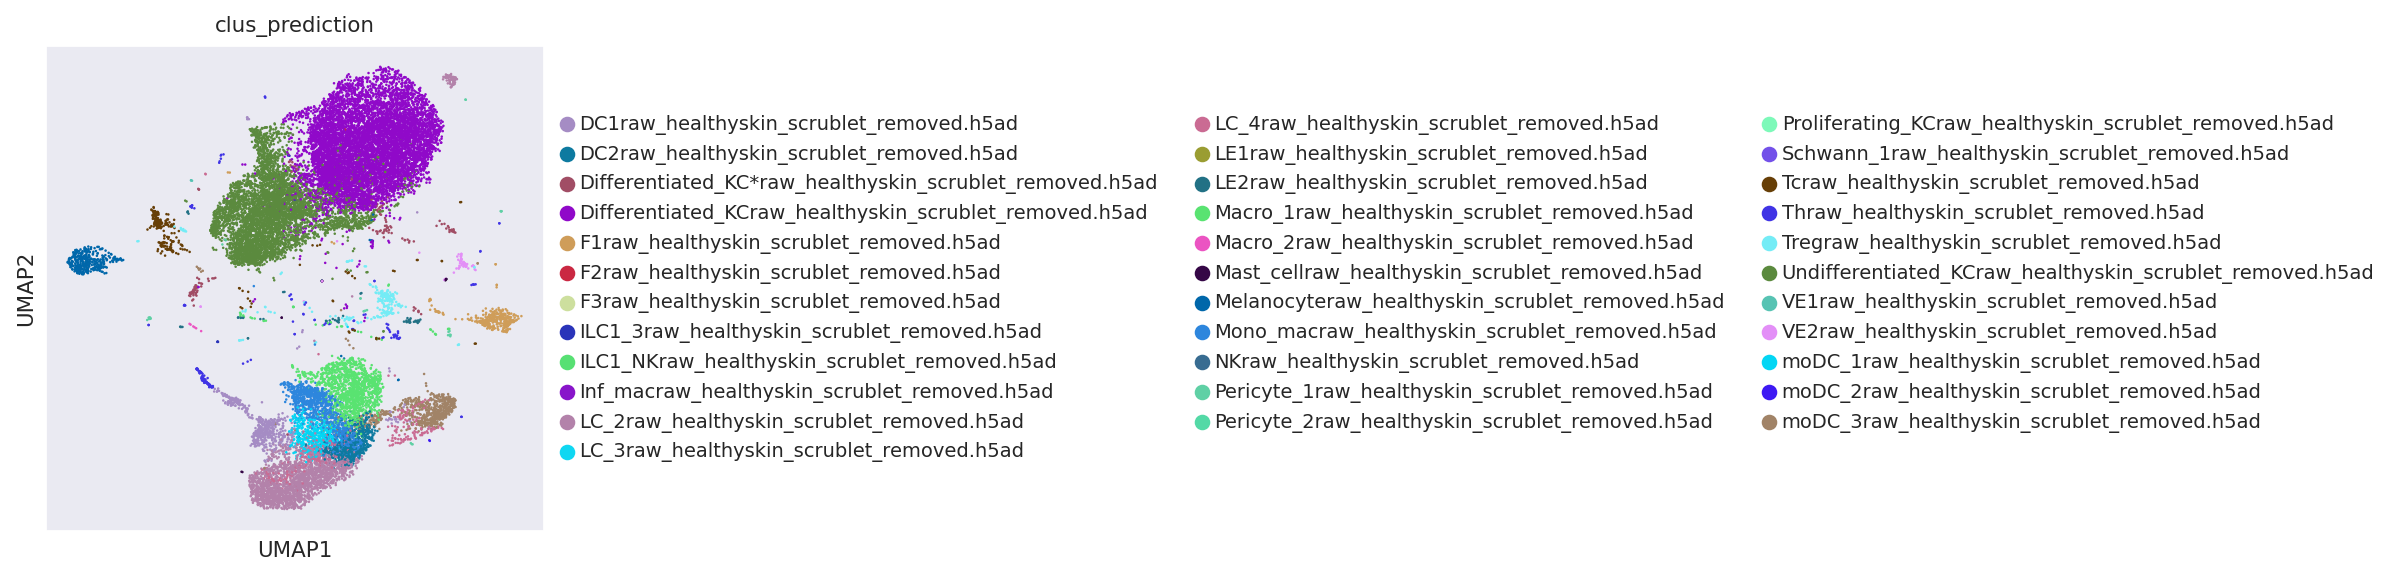

In [15]:
# Generate a umap to view your current data
sc.tl.umap(adata)

def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

col = generate_colors(len(adata.obs["predicted"].unique()))
sc.pl.umap(adata, color='predicted', palette = col, save = "prediction_umap.pdf")

col = generate_colors(len(adata.obs["clus_prediction"].unique()))
sc.pl.umap(adata, color='clus_prediction', palette = col, save = "clus_prediction_umap.pdf")

4 labels were omitted during the consensus redistribution step! Please check if these labels are expected to be significantly available in the prediction dataset! Missin labels are::
################################
{'LC_1raw_healthyskin_scrublet_removed.h5ad', 'ILC2raw_healthyskin_scrublet_removed.h5ad', 'VE3raw_healthyskin_scrublet_removed.h5ad', 'MigDCraw_healthyskin_scrublet_removed.h5ad'}


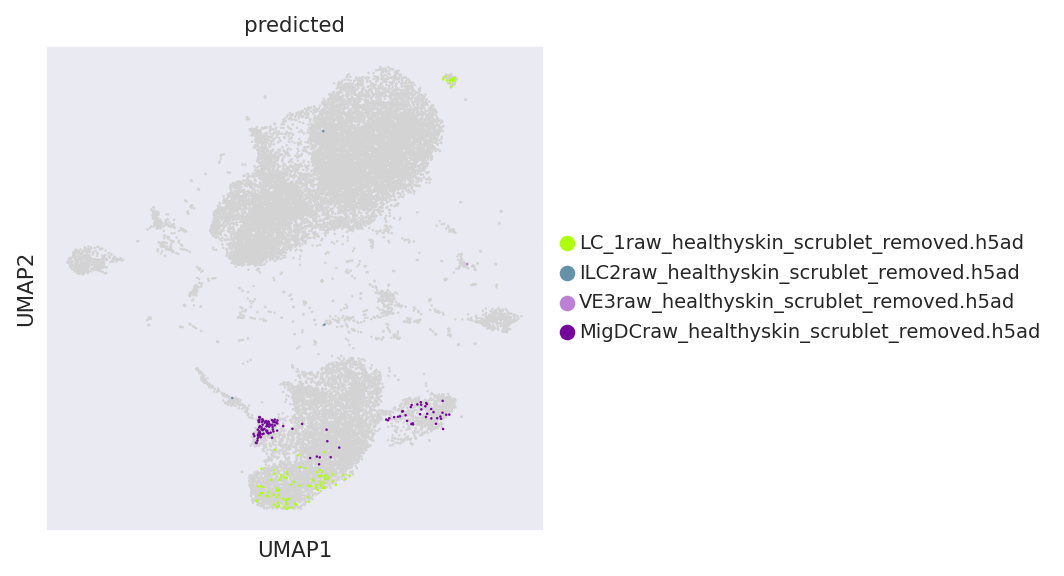

In [16]:
# Are any celltypes removed between prediction and cluster consensus step?
prediction_set = list(adata.obs['predicted'].unique())
clust_prediction_set = list(adata.obs['clus_prediction'].unique())
non_intersect = set(prediction_set) ^ set(clust_prediction_set)
non_intersect = non_intersect.intersection(prediction_set)

if (len(non_intersect)>0):
    print(str(len(non_intersect)) + " labels were omitted during the consensus redistribution step! Please check if these labels are expected to be significantly available in the prediction dataset! Missin labels are::" )
    print("################################")
    print(non_intersect)
    
    # plot umap coloring only labels that were lost in consensus step
    sc.pl.umap(adata,color="predicted",groups=non_intersect, save = "freq_redistribution_omitted_labels_umap.pdf")
else: print("No labels were omitted!")

In [17]:

# calculate Rand and MI
rand = sklearn.metrics.adjusted_rand_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']))
mi = sklearn.metrics.adjusted_mutual_info_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']), 
                                                average_method='arithmetic')

# test concordance between the predicted labels by cell and the consensus clusters
if ((rand<0.8) | (mi<0.8)):
    print("Your concordance between predicted and consensus leiden labels are weak, please attempt reclustering at higher resolution and running consensus again")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))
else: 
    print("success")
    print("You have achieved good consensus between predicted labels and consensus leiden labels")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))

Your concordance between predicted and consensus leiden labels are weak, please attempt reclustering at higher resolution and running consensus again
Adj Rand extimate = 0.801219338120984  Mutual Information score=0.7322608776697017


In [18]:
# Note: if low could be due to removed celltypes or may be expected if the cells are quite different such as from different organs, 
# plot cells to check groups and see if group together nicely or all over 

# Save dataframe with new labels 

In [19]:
df = adata.obs[["predicted", "leiden", "clus_prediction"]]
df = df.rename(columns={"predicted": "pre_freq_clus_prediction", "clus_prediction": "post_freq_clus_prediction"})
df.to_csv(save_path + "/final_lr_metadata_for_adata2.csv")
df

pre_freq_clus_prediction  \
P1_Tumor_AAAGATGAGAAGGTTT    Undifferentiated_KCraw_healthyskin_scrublet_re...   
P1_Tumor_AAAGATGCAATAACGA    Undifferentiated_KCraw_healthyskin_scrublet_re...   
P1_Tumor_AAAGATGCAGACTCGC    Differentiated_KCraw_healthyskin_scrublet_remo...   
P1_Tumor_AAAGATGCAGTCAGCC             VE2raw_healthyskin_scrublet_removed.h5ad   
P1_Tumor_AAAGTAGGTGGCTCCA    Differentiated_KCraw_healthyskin_scrublet_remo...   
...                                                                        ...   
P10_Normal_TTTGGTTCATCATCCC  Undifferentiated_KCraw_healthyskin_scrublet_re...   
P10_Normal_TTTGTCAAGACAATAC       Inf_macraw_healthyskin_scrublet_removed.h5ad   
P10_Normal_TTTGTCAAGTCGTTTG          LC_2raw_healthyskin_scrublet_removed.h5ad   
P10_Normal_TTTGTCACAGTGGGAT          LC_4raw_healthyskin_scrublet_removed.h5ad   
P10_Normal_TTTGTCATCCAGGGCT          LC_2raw_healthyskin_scrublet_removed.h5ad   

                            leiden  \
P1_Tumor_AAAGATGAGAAGGTTT       25   
P1_Tumor_AAAGATGCAATAACGA       25   
P1_Tumor_AAAGATGCAGACTCGC       29   
P1_Tumor_AAAGATGCAGTCAGCC       68   
P1_Tumor_AAAGTAGGTGGCTCCA        4   
...                            ...   
P10_Normal_TTTGGTTCATCATCCC     28   
P10_Normal_TTTGTCAAGACAATAC      5   
P10_Normal_TTTGTCAAGTCGTTTG     56   
P10_Normal_TTTGTCACAGTGGGAT     48   
P10_Normal_TTTGTCATCCAGGGCT      6   

                                                     post_freq_clus_prediction  
P1_Tumor_AAAGATGAGAAGGTTT    Undifferentiated_KCraw_healthyskin_scrublet_re...  
P1_Tumor_AAAGATGCAATAACGA    Undifferentiated_KCraw_healthyskin_scrublet_re...  
P1_Tumor_AAAGATGCAGACTCGC    Differentiated_KCraw_healthyskin_scrublet_remo...  
P1_Tumor_AAAGATGCAGTCAGCC             VE2raw_healthyskin_scrublet_removed.h5ad  
P1_Tumor_AAAGTAGGTGGCTCCA    Differentiated_KCraw_healthyskin_scrublet_remo...  
...                                                                        ...  
P10_Normal_TTTGGTTCATCATCCC  Undifferentiated_KCraw_healthyskin_scrublet_re...  
P10_Normal_TTTGTCAAGACAATAC       Macro_1raw_healthyskin_scrublet_removed.h5ad  
P10_Normal_TTTGTCAAGTCGTTTG          LC_2raw_healthyskin_scrublet_removed.h5ad  
P10_Normal_TTTGTCACAGTGGGAT          LC_4raw_healthyskin_scrublet_removed.h5ad  
P10_Normal_TTTGTCATCCAGGGCT          LC_2raw_healthyskin_scrublet_removed.h5ad  

[23115 rows x 3 columns]